In [6]:
from data import load_all_data
filename = "GBP_EUR.xlsx"
dataset = load_all_data(filename)

print(dataset)
freq = "1D"
prediction_length = 365

train_dataset = dataset["train"]
test_dataset = dataset["test"]
valid_dataset = dataset["validation"]

from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))
valid_dataset.set_transform(partial(transform_start_field, freq=freq))


from gluonts.dataset.multivariate_grouper import MultivariateGrouper
num_of_variates = len(train_dataset)

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates,
    num_test_dates=len(test_dataset) // num_of_variates, # number of rolling test windows
)
valid_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates,
    num_test_dates=len(valid_dataset) // num_of_variates  # if you need a specific number of validation windows
)


multi_variate_train_dataset = train_grouper(train_dataset)
multi_variate_test_dataset = test_grouper(test_dataset)
multi_variate_valid_dataset = valid_grouper(valid_dataset)
print(multi_variate_train_dataset[0]["target"])

from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)
lr = 0.006
weight_decay = 0.1
num_encoder_layers = 3
num_decoder_layers = 4
d_model = 128
from transformers import InformerConfig, InformerForPrediction
config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,
    
    # informer params:
    dropout=0.1,
    encoder_layers=num_encoder_layers,
    decoder_layers=num_decoder_layers,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=d_model,
)
from dataloader import create_train_dataloader, create_backtest_dataloader
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=32,
)

valid_dataloader = create_backtest_dataloader(
    config = config,
    freq=freq,
    data = multi_variate_valid_dataset,
    batch_size=32
)

number of dates: 2868
The dataset has 131 features, each feature has 2868 data points
DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 131
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 131
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 131
    })
})
[[1.6154335  1.6154335  1.6154335  ... 1.3928092  1.3928092  1.3928092 ]
 [1.23102    1.23102    1.23102    ... 1.166652   1.166652   1.166652  ]
 [0.07768952 0.07768952 0.07768952 ... 0.         0.         0.        ]
 ...
 [1.         1.         1.         ... 0.40012684 0.40012684 0.40012684]
 [0.         0.         0.         ... 0.6844283  0.6844283  0.6844283 ]
 [1.         1.         1.         ... 0.2500796  0.2500796  0.2500796 ]]
[1, 2, 3, 4, 5, 6, 7, 8, 13, 

In [7]:

from accelerate import Accelerator
from torch.optim import AdamW
from evaluate import load
from gluonts.time_feature import get_seasonality
from transformers import InformerConfig, InformerForPrediction

EPOCHS = 10
accelerator = Accelerator()
device = accelerator.device
model = InformerForPrediction(config)
model.to(device)
optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=weight_decay)
model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)
model.train()
loss_history = []
for epoch in range(EPOCHS):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 100 == 0:
            print(f"epoch: {epoch}, loss: {loss.item()}")

# perform the evaluation
model.eval()

forecasts_ = []
for batch in valid_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

forecasts = np.vstack(forecasts_)
forecast_median = np.median(forecasts,1).squeeze(0).T


2024-04-15 11:32:08.282402: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 11:33:53.124388: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 11:34:53.908114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


epoch: 0, loss: -193.43585205078125
epoch: 1, loss: -459.7742614746094
epoch: 2, loss: -485.2769775390625
epoch: 3, loss: -472.944580078125
epoch: 4, loss: -419.9711608886719
epoch: 5, loss: -470.77301025390625
epoch: 6, loss: -525.3782958984375
epoch: 7, loss: -538.8428344726562
epoch: 8, loss: -545.371826171875
epoch: 9, loss: -518.4663696289062


In [8]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts,1).squeeze(0).T
print(f"shape for forecast_median is: {forecast_median.shape}")

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_dataset):
    if item_id >= 2: continue
    print(f"item_id={item_id}, ts={ts}")
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])
mase = np.mean(mase_metrics)
print(f"mase: {mase}")


shape for forecast_median is: (131, 365)
item_id=0, ts={'start': Period('2013-01-02', 'D'), 'target': [1.6154334, 1.6154334, 1.6154334, 1.6154334, 1.6154334, 1.6088818, 1.6088818, 1.6088818, 1.6088818, 1.6088818, 1.5949472, 1.5949472, 1.5949472, 1.5949472, 1.5949472, 1.5785682, 1.5785682, 1.5785682, 1.5785682, 1.5785682, 1.5775306, 1.5775306, 1.5775306, 1.5775306, 1.5775306, 1.5700006, 1.5700006, 1.5700006, 1.5700006, 1.5700006, 1.553073, 1.553073, 1.553073, 1.553073, 1.553073, 1.5236256, 1.5236256, 1.5236256, 1.5236256, 1.5236256, 1.5125494, 1.5125494, 1.5125494, 1.5125494, 1.5125494, 1.499524, 1.499524, 1.499524, 1.499524, 1.499524, 1.502544, 1.502544, 1.502544, 1.502544, 1.502544, 1.516009, 1.516009, 1.516009, 1.516009, 1.516009, 1.5181718, 1.5181718, 1.5181718, 1.5181718, 1.5181718, 1.521721, 1.521721, 1.521721, 1.521721, 1.521721, 1.5338384, 1.5338384, 1.5338384, 1.5338384, 1.5338384, 1.5282722, 1.5282722, 1.5282722, 1.5282722, 1.5282722, 1.5386548, 1.5386548, 1.5386548, 1.5386548

In [26]:

import matplotlib.dates as mdates
from gluonts.dataset.field_names import FieldName
import matplotlib.pyplot as plt

df = pd.read_excel(filename, usecols=['Date'])
dates = pd.to_datetime(df['Date'])
dates = dates
last_date = pd.to_datetime('2023-12-29')

# Generate new date range from the day after the last date to the end of 2024
new_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), end='2024-12-28')

dates = pd.concat([dates, pd.Series(new_dates)]).reset_index(drop=True)
dates

def plot(ts_index, mv_index):
    fig, ax = plt.subplots()

    index = dates
    print(f"index is {index}")
    print(f"length of index: {len(index)}")

    ax.xaxis.set_minor_locator(mdates.HourLocator())

    ax.plot(
        index[:-prediction_length],
        multi_variate_valid_dataset[ts_index]["target"][mv_index,:],
        label="actual",
    )

    ax.plot(
        index[-prediction_length:],
        forecasts[ts_index, ..., mv_index].mean(axis=0),
        label="mean",
    )
    ax.legend()
    fig.autofmt_xdate()
    return fig, ax

index is 0      2013-01-02
1      2013-01-03
2      2013-01-04
3      2013-01-07
4      2013-01-08
          ...    
3228   2024-12-24
3229   2024-12-25
3230   2024-12-26
3231   2024-12-27
3232   2024-12-28
Length: 3233, dtype: datetime64[ns]
length of index: 3233


Text(0, 0.5, 'GBP_USD')

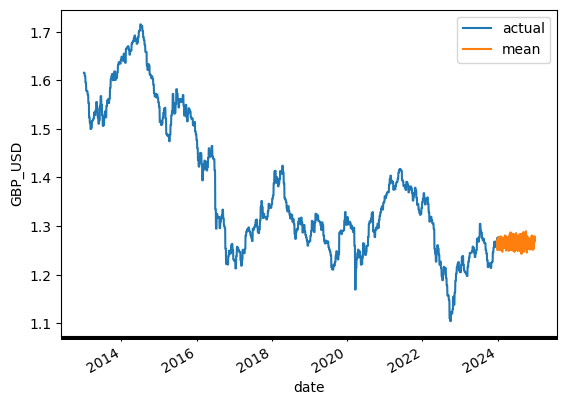

In [27]:
fig, ax = plot(0,0)
ax.set_xlabel('date')
ax.set_ylabel('GBP_USD')
# ax.set_ylim(0,2)

index is 0      2013-01-02
1      2013-01-03
2      2013-01-04
3      2013-01-07
4      2013-01-08
          ...    
2863   2023-12-25
2864   2023-12-26
2865   2023-12-27
2866   2023-12-28
2867   2023-12-29
Name: Date, Length: 2868, dtype: datetime64[ns]
length of index: 2868


Text(0, 0.5, 'GBP_EUR')

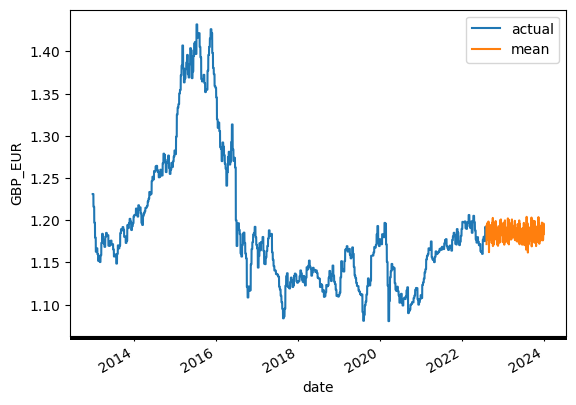

In [11]:
fig, ax = plot(0,1)
ax.set_xlabel('date')
ax.set_ylabel('GBP_EUR')